<a href="https://colab.research.google.com/github/sraeisi/MachineLearning_Physics/blob/master/Lec_3/Model_Selection_complexity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# from google.colab import files
import io, requests, zipfile



'''Set the defaults for your plots.'''
# plt.rcParams.update({'font.size': 20, 'figsize':(8,6)})
SMALL_SIZE = 12
MEDIUM_SIZE = 15
BIGGER_SIZE = 18

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rc('axes', linewidth = 5 )
plt.rc('lines', linewidth = 5 )

plt.rc('lines', markersize = 5 )

plt.rc('figure', figsize=(8,4) )         # Image size

from zipfile import ZipFile


from collections import Counter

import warnings
warnings.filterwarnings('ignore')

from sklearn.utils import shuffle

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Ridge, SGDClassifier
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures , StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error  ## To calculate the loss
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import learning_curve, validation_curve

In [0]:

## This data is collected from https://www.pveducation.org/pvcdrom/appendices/standard-solar-spectra
data = pd.read_excel('https://www.pveducation.org/sites/default/files/PVCDROM/Appendices/AM0AM1_5.xls', header=1)

n_s_rate=10
data = data[data['Wavelength (nm)'] <2500].iloc[::n_s_rate]

X = data['Wavelength (nm)'].values.reshape(-1,1)
scaler = RobustScaler()
scaler.fit(X)
X = scaler.transform(X)

Y = data['Direct+circumsolar W*m-2*nm-1'].values
Y = Y/Y.mean()


In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, random_state=0, test_size=.2)


In [4]:
bbr_data_url = "https://github.com/sraeisi/MachineLearning_Physics/blob/master/Lec_1/bbr.xls?raw=true"

bbr_data = pd.read_excel(bbr_data_url)

X = bbr_data[0].values.reshape(-1,1)
scaler = RobustScaler()
scaler.fit(X)
X = scaler.transform(X)





Y = bbr_data['T'].values
Y = Y/Y.mean()
noise = np.random.normal(0, .5, Y.shape)
Y = Y + noise
print(Y.shape)

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, random_state=0, test_size=.4)


(771,)


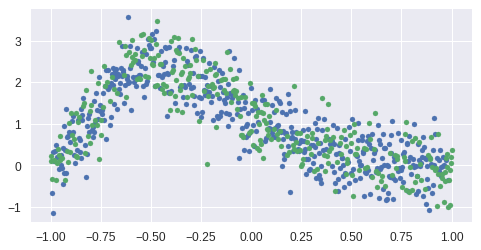

In [5]:
plt.scatter(X_train,Y_train)
plt.scatter(X_test,Y_test)
plt.show()

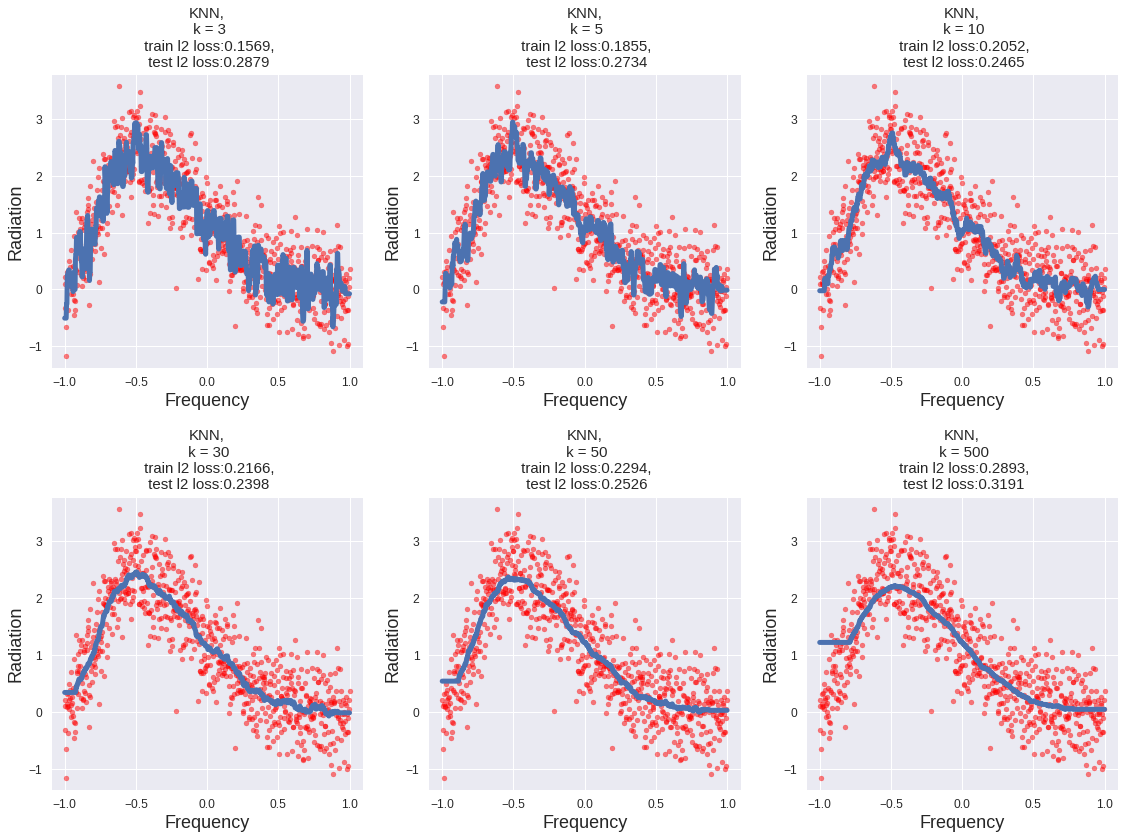

CPU times: user 1.44 s, sys: 601 ms, total: 2.05 s
Wall time: 1.28 s


In [6]:
%%time

x_label = 'Frequency'
y_label = 'Radiation'
plt_title = 'Black Body Radiation'

## Define a set of trees with different parameters. 
reg_dict = {'KNN,\n k = 3':KNeighborsRegressor(n_neighbors=3)
            ,'KNN,\n k = 5':KNeighborsRegressor(n_neighbors=5)
            ,'KNN,\n k = 10':KNeighborsRegressor(n_neighbors=10)
            ,'KNN,\n k = 30':KNeighborsRegressor(n_neighbors=30)
            ,'KNN,\n k = 50':KNeighborsRegressor(n_neighbors=50)
            ,'KNN,\n k = 500':KNeighborsRegressor(n_neighbors=100) }



fig = plt.figure(figsize=(16,12))
for reg_id in list(reg_dict.keys())[:]:
    
    plt_ind = list(reg_dict.keys()).index(reg_id)+1
    
    
    reg = reg_dict[reg_id]
    reg.fit(X_train,Y_train)
    l_train = mean_squared_error( Y_train, reg.predict(X_train) )
    l_test  = mean_squared_error( Y_test, reg.predict(X_test) )
    
    ax = fig.add_subplot(2, 3, plt_ind , xlabel = x_label, ylabel=y_label, 
                         title = reg_id+'\n train l2 loss:{0:.4f},\n test l2 loss:{1:.4f}'.format(l_train, l_test ))
    
    
    ax.scatter(X,Y, color='r', alpha=.5)
    ax.plot(X, reg.predict( X )  )


plt.tight_layout()
# fig.savefig("classification_comparision_particle_identification.pdf")
plt.show()

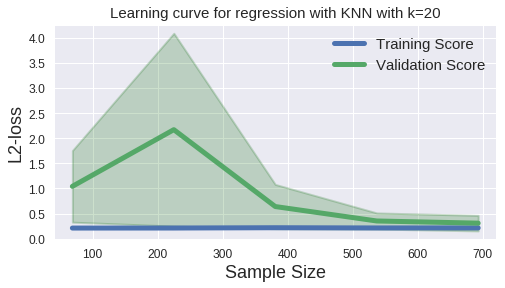

CPU times: user 713 ms, sys: 190 ms, total: 903 ms
Wall time: 791 ms


In [27]:
%%time
k=20
ns_list, train_scores, validation_scores = learning_curve(
                                                   estimator = KNeighborsRegressor(n_neighbors=k,n_jobs=-1), X = X,
                                                   y = Y,  cv = 10,
                                                   scoring = 'neg_mean_squared_error', random_state=11)

train_scores_mean = - train_scores.mean(axis = 1)
train_scores_std = np.std(train_scores, axis=1)
validation_scores_mean = - validation_scores.mean(axis = 1)
validation_scores_std  = validation_scores.std(axis = 1)

xlabel = 'Sample Size'
ylabel = 'L2-loss'

plt_title = 'Learning curve for regression with KNN with k={}'.format(k)

fig = plt.figure()
ax = fig.add_subplot(111, xlabel=xlabel, ylabel=ylabel, title=plt_title)
ax.plot(ns_list, train_scores_mean, label = 'Training Score')
ax.plot(ns_list, validation_scores_mean, label = 'Validation Score')

plt.fill_between(ns_list, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkblue", lw=2)
plt.fill_between(ns_list, validation_scores_mean - validation_scores_std,
                 validation_scores_mean + validation_scores_std, alpha=0.2,
                 color="darkgreen", lw=2)


ax.legend(loc=0)
plt.show()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 340 out of 340 | elapsed:    1.5s finished


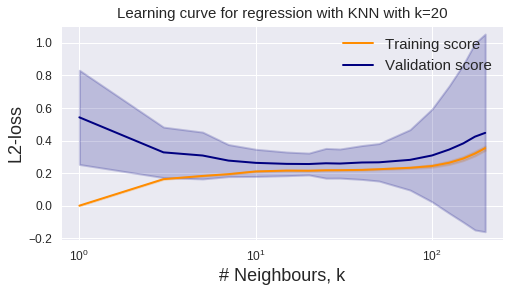

In [33]:
### Validation Curve
k_list = [1,3,5,7,10, 15, 20, 25, 30, 40, 50 , 75,  100, 125, 150, 175, 200]
train_scores, valid_scores = validation_curve(KNeighborsRegressor(), X, Y, 
                                              param_name="n_neighbors",
                                              param_range=k_list , cv=20, 
                                              scoring = 'neg_mean_squared_error',
                                              verbose=1, n_jobs=-1
                                             )

train_scores_mean = - np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = - np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)


xlabel = '# Neighbours, k'
ylabel = 'L2-loss'

ptl_title = 'Validation curve for regression with KNN with k={}'.format(k)

fig = plt.figure()
ax = fig.add_subplot(111, xlabel=xlabel, ylabel=ylabel, title=plt_title)
plt.semilogx(k_list, train_scores_mean, label="Training score",
             color="darkorange", lw=2)
plt.fill_between(k_list, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=2)
plt.semilogx(k_list, valid_scores_mean, label="Validation score",
             color="navy", lw=2)
plt.fill_between(k_list, valid_scores_mean - valid_scores_std,
                 valid_scores_mean + valid_scores_std, alpha=0.2,
                 color="navy", lw=2)
plt.legend(loc="best")
plt.show()

In [0]:
### Gridsearch
'''
Here's how we can search for the best value of k. 
'''
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


In [0]:
%%time
params = {'n_neighbors':k_list}
knn = KNeighborsRegressor()
reg_gs = GridSearchCV(knn, param_grid=params, n_jobs=-1, verbose=1, cv=50, refit=True, scoring=['neg_mean_squared_error','neg_mean_absolute_error'])
reg_gs.fit(X, Y)
print( reg_gs.best_params_ )


In [55]:
print( reg_gs.best_params_ )
print(reg_gs.best_score_)
reg_gs.predict(X[:2])

{'n_neighbors': 25}
-0.23334919547171457


array([0.04702484, 0.04702484])

In [58]:
%%time
clf = SVR()
# params = {'kernel':['linear', 'poly', 'rbf', 'sigmoid']}
# params = {'degree':[1,2,3,4,5,6,7,8,9,10,11,12], 'gamma':[.001, .01,.1,1,10], 'C':[.001,.01,.1], 'epsilon' : [.001,.01,.1]}
params = {'kernel':('linear', 'poly', 'rbf', 'sigmoid'),'degree':[3,4],'gamma':[11,12,13,14], 'C':[.015,.02,.04], 'epsilon' : [.0015,.002,.004]}
params = {'kernel':('poly', 'rbf'),'degree':[3,4]}
clf_gs = GridSearchCV(clf, param_grid=params, n_jobs=-1, verbose=1, cv=5)
clf_gs.fit(X_train, Y_train)
print(clf_gs)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'kernel': ('poly', 'rbf'), 'degree': [3, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)
CPU times: user 67.9 ms, sys: 23.5 ms, total: 91.4 ms
Wall time: 1.35 s


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    1.3s finished


In [59]:
print(clf_gs.best_params_)
print(clf_gs.best_score_)

{'degree': 3, 'kernel': 'rbf'}
0.7330123898024501


## Exercise1: Redo what we did for the following data. 
Optional:
Instead of KNN, use Linear Regression with polynomial features.

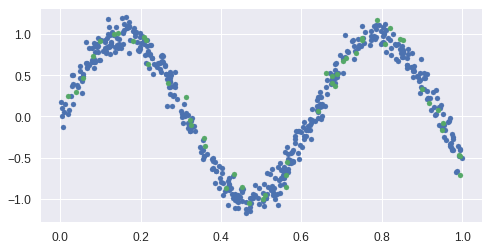

In [63]:
def make_data(n_samples, mu=0, sigma=1):
  x_list = np.sort( np.random.uniform(0,1,n_samples) )
  y_list = np.sin(10*x_list) + np.random.normal(mu, sigma, n_samples)
  return x_list.reshape(-1,1), y_list


def loss(y,y_predicted):
  return np.sqrt(np.linalg.norm(y-y_predicted))/len(y)

X_train, Y_train = make_data(500, sigma=.1)
X_test, Y_test = make_data(50, sigma=.1)


plt.scatter(X_train,Y_train)
plt.scatter(X_test, Y_test)
plt.show()

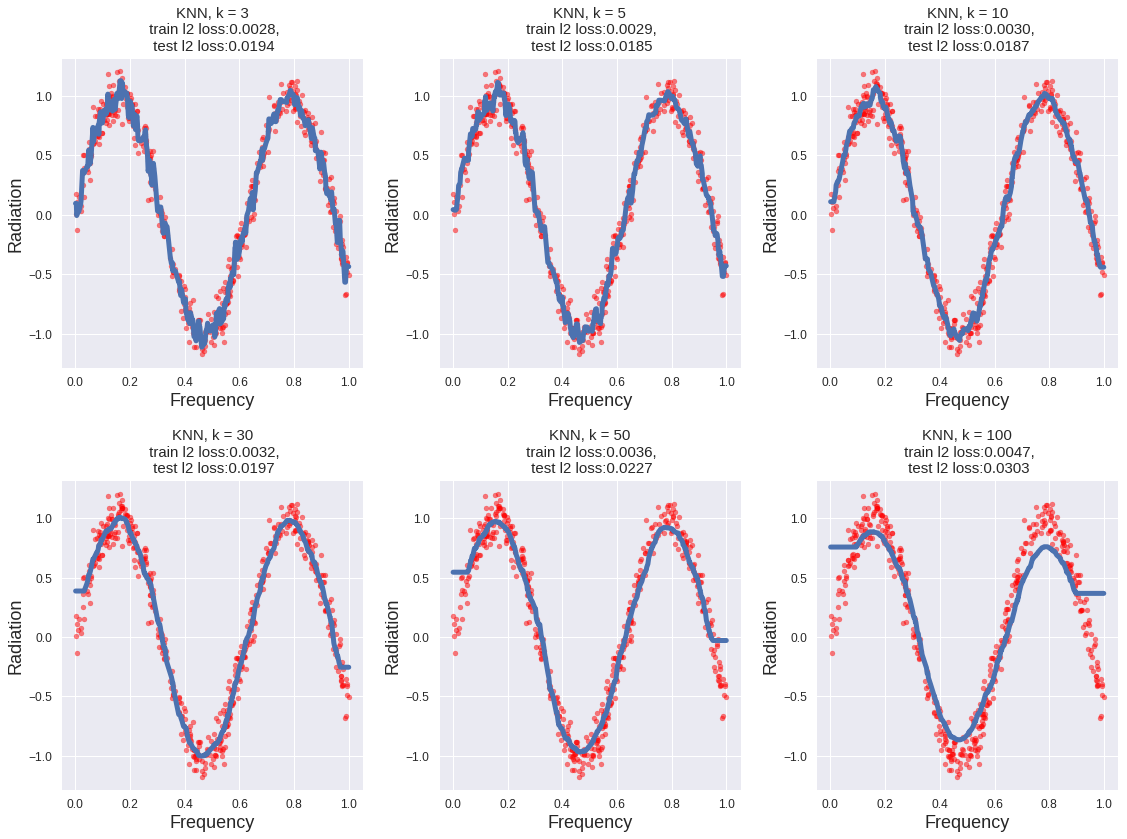

CPU times: user 1.43 s, sys: 589 ms, total: 2.02 s
Wall time: 1.27 s


In [64]:
%%time

x_label = 'Frequency'
y_label = 'Radiation'
plt_title = 'Black Body Radiation'

## Define a set of trees with different parameters. 
reg_dict = {'KNN, k = 3':KNeighborsRegressor(n_neighbors=3)
            ,'KNN, k = 5':KNeighborsRegressor(n_neighbors=5)
            ,'KNN, k = 10':KNeighborsRegressor(n_neighbors=10)
            ,'KNN, k = 30':KNeighborsRegressor(n_neighbors=30)
            ,'KNN, k = 50':KNeighborsRegressor(n_neighbors=50)
            ,'KNN, k = 100':KNeighborsRegressor(n_neighbors=100) }



fig = plt.figure(figsize=(16,12))
for reg_id in list(reg_dict.keys())[:]:
    
    plt_ind = list(reg_dict.keys()).index(reg_id)+1
    
    
    reg = reg_dict[reg_id]
    reg.fit(X_train,Y_train)
    l_train = loss( Y_train, reg.predict(X_train) )  #mean_squared_error( Y_train, reg.predict(X_train) )
    l_test  = loss( Y_test, reg.predict(X_test) )    #mean_squared_error( Y_test, reg.predict(X_test) )

    
    ax = fig.add_subplot(2, 3, plt_ind , xlabel = x_label, ylabel=y_label, 
                         title = reg_id+'\n train l2 loss:{0:.4f},\n test l2 loss:{1:.4f}'.format(l_train, l_test ))
    
    
    ax.scatter(X_train,Y_train, color='r', alpha=.5)
    ax.plot(X_train, reg.predict( X_train )  )


plt.tight_layout()
# fig.savefig("classification_comparision_particle_identification.pdf")
plt.show()